In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime
import sqlite3
from IPython.core.display import HTML
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [2]:
#utility functions
#timeSplit function will seperate data in 70-30%
def timeSplit(data):
    noOfRows=data.shape[0]
    seperatePoint= int(noOfRows * 0.70)
    train_review_x=data[:seperatePoint,:]
    test_review_x=data[seperatePoint:,:]
    train_label_y=data_sample['Score'].iloc[:seperatePoint]
    test_label_y=data_sample['Score'].iloc[seperatePoint:]
    return train_review_x,test_review_x,train_label_y,test_label_y

In [3]:
#connection to already cleaned data which we have done in previous assignments and selection of data time wise 
#so we can easily do time based splitting
conn = sqlite3.connect('finalData.sqlite')
data_sample = pd.read_sql_query("select * from REVIEWS order by Time",conn)

In [4]:
#changing class label to numeric from character
data_sample["Score"]= data_sample["Score"].replace({'p':1,'n':0})

In [5]:
#BoW of cleaned text column in clean data
count_vect = CountVectorizer() #in scikit-learn
bow_counts = count_vect.fit_transform(data_sample['CleanedText'])


In [6]:

train_review_x,test_review_x,train_label_y,test_label_y=timeSplit(bow_counts)
# print("train_review_x :: ",train_review_x.shape)
# print("test_review_x :: ",test_review_x.shape)
# print("train_label_y :: ",train_label_y.shape)
# print("test_label_y :: ",test_label_y.shape)

In [7]:
#10-fold cross validation for finding optimal alpha
cv_scores = [-1]
listNumber=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha=-1
    while r < stop:
        listNumber.append(r)
        classDemo = BernoulliNB(alpha=r) 
        scores = cross_val_score(classDemo, train_review_x, train_label_y, cv=10, scoring='accuracy')
        scores_mean=scores.mean()
        if(scores_mean>max(cv_scores)):
            optimal_alpha=r
        cv_scores.append(scores_mean)
        r += step
    return optimal_alpha
v=rangfunc(0.001,10,0.1)
print("optimal_alpha",v)


optimal_alpha 0.001


In [8]:
cv_scores.pop(0)

-1

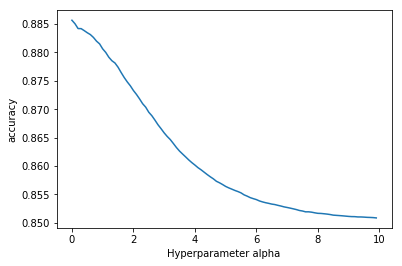

In [9]:
#graph of hyperparameter alpha versus accuracy
plt.plot(listNumber, cv_scores)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('accuracy')
plt.show()

<b>as the hyper parameter value increasing accuracy is decreasing.</b>

In [10]:
actualDemo = BernoulliNB(alpha=0.001) 
actualDemo.fit(train_review_x,np.array(train_label_y))

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [11]:
predicted= actualDemo.predict(test_review_x)

In [12]:
accuracy_score(test_label_y, predicted)

0.8743821623402775

<b>accuracy_score for bag of words with alpha 0.001  is 0.874</b>

In [13]:
f1_score(test_label_y, predicted)

0.9237284367775208

<b>f1 score for bag of words is 0.923</b>

In [53]:
print("precesion for BOW with alpha 0.001 is",precision_score(test_label_y, predicted, average="macro"))
print("Recall for BOW with alpha 0.001 is",recall_score(test_label_y, predicted, average="macro"))  

precesion for BOW with alpha 0.001 is 0.7816340101146917
Recall for BOW with alpha 0.001 is 0.7863314824730137


In [14]:
confusion_matrix(test_label_y, predicted)

array([[12422,  6659],
       [ 7065, 83106]], dtype=int64)

In [15]:
confusion_matrix(test_label_y, predicted).ravel()

array([12422,  6659,  7065, 83106], dtype=int64)

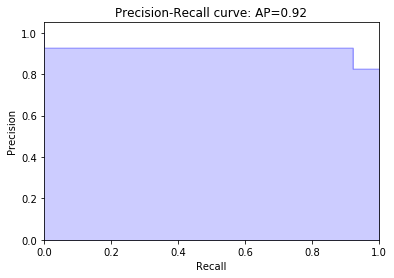

In [52]:
average_precision = average_precision_score(test_label_y, predicted)
precision, recall, _ = precision_recall_curve(test_label_y, predicted)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()


In [37]:
def important_features(vectorizer,classifier,n=20):
        class_labels = classifier.classes_
        feature_names =vectorizer.get_feature_names()
        topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
        topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
        print("Important words in negative reviews")
        for coef, feat in topn_class1:
            print(class_labels[0], coef, feat)
        print("-----------------------------------------")
        print("Important words in positive reviews")
        for coef, feat in topn_class2:
            print(class_labels[1], coef, feat) 

<b>Important features in BOW.</b>

In [42]:
important_features(count_vect,actualDemo, n=10)

Important words in negative reviews
0 14212.0 tast
0 13957.0 like
0 11298.0 product
0 9807.0 one
0 9183.0 would
0 8750.0 tri
0 8100.0 flavor
0 8048.0 good
0 7584.0 buy
0 7171.0 get
-----------------------------------------
Important words in positive reviews
1 65877.0 like
1 64408.0 tast
1 60613.0 love
1 60171.0 good
1 59088.0 great
1 51578.0 flavor
1 49633.0 one
1 48724.0 use
1 46578.0 tri
1 45059.0 product


<b>Naive Bayes with TF-IDF</b>

In [17]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(data_sample['CleanedText'])


In [18]:
train_review_xt,test_review_xt,train_label_yt,test_label_yt=timeSplit(final_tf_idf)

In [19]:
#10-fold cross validation for finding optimal alpha(tf-idf)
cv_scores_tfidf = [-1]
listNumber_tfidf=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha_tfidf=-1
    while r < stop:
        listNumber_tfidf.append(r)
        classDemotfidf = BernoulliNB(alpha=r) 
        scores_tfidf = cross_val_score(classDemotfidf, train_review_xt, train_label_yt, cv=10, scoring='accuracy')
        scores_mean_tfidf=scores_tfidf.mean()
        if(scores_mean_tfidf>max(cv_scores_tfidf)):
            optimal_alpha_tfidf=r
        cv_scores_tfidf.append(scores_mean_tfidf)
        r += step
    return optimal_alpha_tfidf
opt_v=rangfunc(0.001,10,0.1)
print("optimal_alpha",opt_v)

optimal_alpha 0.001


In [20]:
cv_scores_tfidf.pop(0)
cv_scores_tfidf

[0.900152597985759,
 0.8685503936332359,
 0.8598339107916748,
 0.8545694941125632,
 0.8507722120697162,
 0.8478536361488791,
 0.8464375014430996,
 0.8456568599176938,
 0.8447349985404806,
 0.8440249667870889,
 0.8436562205741961,
 0.8434483117491192,
 0.8436993730593871,
 0.8441230370776077,
 0.8443858654007981,
 0.8447585321046567,
 0.8451665055411975,
 0.8455509426435496,
 0.8459746058923224,
 0.8462962762051566,
 0.8466140241803499,
 0.8468847004105029,
 0.847127915198814,
 0.8473789751240753,
 0.8475476564177253,
 0.8478026391422964,
 0.8479909342786044,
 0.848234148143578,
 0.8483989064840285,
 0.8484655934567332,
 0.8485675862387826,
 0.8487244985189453,
 0.8488500279429623,
 0.8489598664775204,
 0.8490893191625158,
 0.849175621055106,
 0.8493286102281798,
 0.8493835297262933,
 0.8494423720237163,
 0.849556133357584,
 0.8496698949992307,
 0.8497287380661016,
 0.8498032717146525,
 0.8498503456141467,
 0.8499131107108792,
 0.8499680299012133,
 0.8500151034929285,
 0.850038640596565

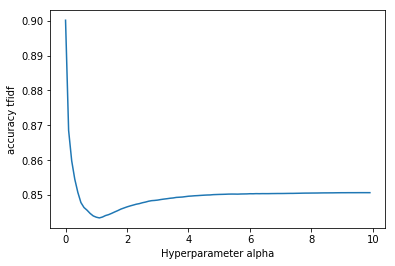

In [21]:
#graph of hyperparameter alpha versus accuracy tf-idf
plt.plot(listNumber_tfidf, cv_scores_tfidf)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('accuracy tfidf')
plt.show()

<b>in starting with alpha value accuracy is very high but suddenly with the alpha increasing accuracy decreased and then become nearly stable.</b>

In [22]:
actualDemotfidf = BernoulliNB(alpha=0.001) 
actualDemotfidf.fit(train_review_xt,np.array(train_label_yt))

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [23]:
predicted_tfidf= actualDemotfidf.predict(test_review_xt)

In [24]:
accuracy_score(test_label_yt, predicted_tfidf)

0.8906564639548933

<b>accuracy_score for TF-iDF with alpha 0.001 is 0.890</b>

In [25]:
f1_score(test_label_yt, predicted_tfidf)

0.9354340071343639

<b>f1 score for TF-iDF is 0.935</b>


In [26]:
confusion_matrix(test_label_yt, predicted_tfidf)

array([[10769,  8312],
       [ 3634, 86537]], dtype=int64)

In [50]:
print("precesion for TF-IDF with alpha 0.001 is",precision_score(test_label_yt, predicted_tfidf, average="macro"))
print("Recall for TF-IDF with alpha 0.001 is",recall_score(test_label_yt, predicted_tfidf, average="macro"))  

0.8300287121723575
0.7620411062862491


In [27]:
confusion_matrix(test_label_yt, predicted_tfidf).ravel()

array([10769,  8312,  3634, 86537], dtype=int64)

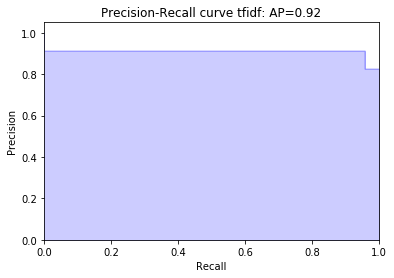

In [51]:
average_precision_tfidf = average_precision_score(test_label_yt, predicted_tfidf)
precision_tfidf, recall_tfidf, _ = precision_recall_curve(test_label_yt, predicted_tfidf)

plt.step(recall_tfidf, precision_tfidf, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_tfidf, precision_tfidf, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve tfidf: AP={0:0.2f}'.format(
          average_precision))
plt.show()


<b>Important features in TF-IDF.</b>

In [41]:
important_features(tf_idf_vect,actualDemotfidf, n=20)

Important words in negative reviews
0 14212.0 tast
0 13957.0 like
0 11298.0 product
0 9807.0 one
0 9183.0 would
0 8750.0 tri
0 8100.0 flavor
0 8048.0 good
0 7584.0 buy
0 7171.0 get
0 6871.0 use
0 6560.0 dont
0 6096.0 even
0 5981.0 order
0 5318.0 much
0 5280.0 make
0 5012.0 realli
0 4994.0 time
0 4867.0 love
0 4745.0 amazon
-----------------------------------------
Important words in positive reviews
1 65877.0 like
1 64408.0 tast
1 60613.0 love
1 60171.0 good
1 59088.0 great
1 51578.0 flavor
1 49633.0 one
1 48724.0 use
1 46578.0 tri
1 45059.0 product
1 41686.0 make
1 39725.0 get
1 32146.0 buy
1 31902.0 time
1 30539.0 would
1 30491.0 best
1 29958.0 find
1 29744.0 realli
1 28701.0 price
1 28445.0 amazon


<b>Summary</b>

<img src="files/Naive_Bayes.jpg">

<b>from above summary ,we can say that results from TF-IDF and BOW's results are almost nearer but statistical comparison says TF-IDf perfomed better.</b>